# MU4MA074 Projet: Implémentation de la méthode du rejet pour la simulation des lois tronquées et influence de la dimension sur la performance de la méthode

**membres du groupe: HuixinCHEN**(21319577) **KeWANG**(21319589)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch

## 1. Méthode du rejet

### 1.1 Présentation du problème et de l'algorithme
On va présenter la méthode d'estimation et les étapes principales de l'algorithme.

#### 1.1.1 Cadre théorique

***Objectif :*** simuler une variable aléatoire suivant une densité cible $f(x)$, définie sur un espace mesurable $E$ muni d'une mesure de référence $\mu$ (souvent la mesure de Lebesgue).

Soit $(E, \mathcal{E}, \mu)$ un espace mesuré, où $\mu$ est une mesure positive $\sigma$-finie. La loi cible $\nu$ est absolument continue par rapport à $\mu$, admettant une densité $f$ telle que $\nu = f \mu$ et $\int_E f \, d\mu = 1$.

Comme la simulation directe selon $f$ peut être difficile, on utilise la **méthode du rejet**, en s'appuyant sur une **densité auxiliaire** $g(x)$ plus simple à simuler. Cette densité $g$ est absolument continue par rapport à $\mu$, vérifie $g(x) > 0$ $\mu$-presque partout, et il existe une constante $c \geq 1$ telle que $f(x) \leq c \, g(x)$ pour tout $x \in E$.

La procédure consiste à générer une suite de variables $(X_k)_{k\geq1}$ indépendantes suivant $g$, ainsi qu'une suite $(U_k)_{k\geq1}$ indépendantes suivant la loi uniforme sur $[0,1]$. Un échantillon $X_k$ est accepté si $U_k \leq \dfrac{f(X_k)}{c g(X_k)}$, et rejeté sinon. Le premier échantillon accepté suit alors la loi $\nu$.

*Cette approche sera détaillée dans la section 1.1.2 suivante.*


---

##### ***Taux d’acceptation et constante $c$***

Nous nous intéressons maintenant à la probabilité d'acceptation d'un échantillon généré selon $g$.
La **probabilité d'acceptation** d'un tirage $X_k \sim g$ est donnée par :

$$
\mathbb{P}\left(U_k \leq \frac{f(X_k)}{c \cdot g(X_k)}\right)
= \int_E \mathbb{P}\left(U_k \leq \frac{f(x)}{c \cdot g(x)}\right) g(x) \, dx
= \int_E \frac{f(x)}{c \cdot g(x)} g(x) \, dx
= \frac{1}{c} \int_E f(x) \, dx = \frac{1}{c}.
$$

Ainsi, la constante $c$ contrôle directement le taux d'acceptation : plus $c$ est grand, plus le taux est faible, et plus le nombre moyen de tentatives nécessaires augmente.  
Le **coût moyen** de la méthode est donc proportionnel à $c$.

Il est essentiel de choisir une densité auxiliaire $g$ proche de la densité cible $f$ afin de minimiser $c$ et optimiser l'efficacité du rejet.

Dans la suite, le taux d'acceptation sera utilisé comme indicateur principal de performance, notamment pour étudier ***l'effet de la dimension***.

#### 1.1.2 Méthode algorithmique

***Idée :*** Accepter un échantillon $x$ simulé selon $g$ avec une probabilité donnée par :

$$
\frac{f(x)}{c \cdot g(x)},
$$
où $c \geq 1$ est une constante telle que $f(x) \leq c \cdot g(x)$ pour tout $x$.

***Algorithme : Méthode du rejet***

> **Donnée** : Une distribution de proposition $g$ et une densité cible $f$  
>  
> **Résultat** : Un échantillon suivant la distribution $f$  
>
> Choisir une constante optimale $c^*$    
> Répéter :  
> > Générer $X \sim g$.  
> > Générer $U \sim \mathcal{U}(0,1)$.
> > **if** $U \leq \dfrac{f(X)}{c^* \cdot g(X)}$ **then**  
> >   accepter $X$ comme échantillon et sortir de la boucle  
> > **else**  
> >   rejeter $X$ et recommencer
> 
> until un échantillon est accepté.

##### ***Choix optimal de $c^*$***

Pour maximiser le taux d’acceptation, on choisit :

$$
c^* = \sup_{x \in [-a,a]} \frac{f(x)}{g(x)}
$$

Généralement, par exemple si la densité cible n’est pas symétrique ou connue explicitement, on ne connaît pas forcément ce maximum de manière analytique.  
On peut alors **l’approximer numériquement** à l’aide d’un algorithme d’optimisation unidimensionnel, comme la méthode `"bounded"` de `scipy.optimize.minimize_scalar`.

### 1.2 Difficulté : Limites de la méthode du rejet dans un espace de grande dimension

Bien que la méthode du rejet soit simple et largement utilisée, elle devient rapidement inefficace en grande dimension. Le principal problème réside dans la forte diminution du **taux d'acceptation** lorsque la dimension augmente.

En effet, le taux d'acceptation moyen est donné par $\frac{1}{c}$, où $c$ est une constante de majoration telle que $f(x) \leq c \cdot g(x)$ pour tout $x$. Or, dans un espace de grande dimension, il devient **de plus en plus difficile de construire une densité auxiliaire $g$ qui majore efficacement $f$** sur tout le support, ce qui conduit à une croissance exponentielle de $c$ avec la dimension $d$, et donc à un taux d’acceptation tendant vers zéro.

Autrement dit, la méthode du rejet **éprouve des difficultés d'extension aux hautes dimensions**, ce qui en limite fortement l'usage pour des problèmes complexes.  
Nous étudierons ce phénomène en analysant l'évolution du taux d'acceptation en fonction de la dimension.

## 2. La méthode du rejet pour la simulation de la loi Laplace tronquée
Parmi les lois à décroissance exponentielle, la loi de Laplace présente l’avantage d’une densité analytique simple, symétrique, et facile à tronquer. Cela en fait un bon candidat pour tester la robustesse de la méthode du rejet dans des cas simples mais représentatifs. Nous allons maintenant appliquer la méthode du rejet à une loi de Laplace tronquée, avec une attention particulière à la densité et à la procédure de simulation.

### 2.1 Densité et normalisation

On rappelle la forme de la densité de la loi de dimension 1 :

$$
f_{\mu, b}(x) = \frac{1}{2b} \exp\left(-\frac{|x - \mu|}{b}\right), \quad x \in \mathbb{R}.
$$

- $\mu$ contrôle la position centrale de la distribution (c’est-à-dire l’axe de **symétrie**) ;
- $b$ contrôle la dispersion de la distribution (jouant un rôle similaire à l’écart-type) ;
- la densité atteint son maximum en $\mu$ et décroît exponentiellement de part et d’autre.



En particulier, la densité centrée en $\mu$ décroît exponentiellement de part et d'autre du centre, ce qui rend la simulation par méthode du rejet particulièrement intéressante dans ce cas.

---

Dans ce qui suit, nous considérons la loi de Laplace **tronquée**.
En raison de la symétrie de la densité, il est naturel de fixer les paramètres $\mu = 0$ et $b = 1$ dans l'intervalle $[a, a']$. La forme de la densité de la loi de Laplace tronquée est donnée par :

$$
f_{\text{trunc}}(x) =
\begin{cases}
\displaystyle \frac{1}{Z} \cdot \frac{1}{2} e^{-|x|}, & x \in [a, a'] \\
0, & \text{sinon}
\end{cases}
$$

où la constante de normalisation $Z$ est :

$$
Z = {\text{CDF}}(a') - {\text{CDF}}(a) = \frac{1}{2} \left(
\mathbf{1}_{a < 0 < a'} \left(1 - e^{a} + 1 - e^{-a'} \right)
+ \mathbf{1}_{a' \leq 0}(e^{a'} - e^{a})
+ \mathbf{1}_{a \geq 0}(e^{-a} - e^{-a'})
\right)
$$

où CDF désigne la fonction de répartition de la loi de Laplace *standard*.

### 2.2 Simulation de la loi de Laplace tronquée par rejet avec une loi uniforme auxiliaire
Afin d'introduire visuellement la méthode du rejet,  nous simulons ici la loi de Laplace tronquée à l'aide d'une **loi uniforme tronquée** utilisée comme densité auxiliaire.
En raison de la symétrie de la loi de Laplace, nous fixons directement $\mu = 0$, et nous analyserons ensuite le comportement de la méthode pour des intervalles de troncature symétriques et asymétriques.

Nous présenterons successivement :
- le cas unidimensionnel (avec une distinction entre troncature symétrique et asymétrique),
- le cas bidimensionnel,
- puis l'extension à des dimensions supérieures.

#### 2.2.1 Simulation en *unidimension $d = 1$* : loi de Laplace centrée tronquée par une loi uniforme
Nous nous plaçons désormais en **dimension d=1**, et nous considérons une loi de Laplace centrée tronquée sur un intervalle, en utilisant une loi uniforme tronquée comme densité auxiliaire.

##### ***- Intervalle symétrique***
Comme point de départ, considérons la loi de Laplace tronquée de paramètres $\mu = 0$ et $b = 1$ sur un intervalle symétrique  $[-a, a]$. Nous choisissons alors comme loi auxiliaire la loi uniforme sur le même intervalle, qui s’écrit sous forme de densité : 

$$
g(x) = \frac{1}{2a} \mathbf{1}_{[-a,a]}(x).
$$

Dans cette configuration simple, il est naturel de chercher à optimiser la constante $c$ afin d'améliorer l’efficacité du rejet, conformément aux principes présentés précédemment.

La constante optimale $c^*$ associée à cette configuration est donnée par :

$$
c^* = \max_{x \in [-a,a]} \frac{f_{\text{Laplace}}(x)}{g(x)} = \frac{f_{\text{Laplace}}(x^*)}{g(x^*)},
$$

où $f_{\text{Laplace}}$ désigne la densité **tronquée** de la loi de Laplace :

$$
f_{\text{Laplace}}(x) = \frac{1}{Z} \cdot \frac{1}{2b} e^{-\frac{|x|}{b}}, \quad \text{avec} \quad Z = \int_{-a}^a \frac{1}{2b} e^{-\frac{|x|}{b}} dx = \text{CDF}(a) - \text{CDF}(-a).
$$

Dans le cas de la loi de Laplace centrée, cette densité atteint son maximum en $x^* = 0$, ce qui donne :

$$
c^* = \frac{f(0)}{g(0)} = \frac{1}{Z \cdot 2b} \cdot 2a = \frac{a}{bZ}. \tag{1}
$$

In [2]:
a,b = 3,1
distrib = stats.laplace(scale=b)
Z = distrib.cdf(a) - distrib.cdf(-a)
g = 1/(2*a)

res = optimize.minimize_scalar(lambda x: -distrib.pdf(x) / (g*Z), bounds=(-a, a), method="bounded")
print(res)

c = -res.fun
print("Optimal value: ", c)
print("Theoretical value:", a/(b*Z))

 message: Solution found.
 success: True
  status: 0
     fun: -3.157187089473766
       x: 5.551115123125783e-16
     nit: 14
    nfev: 14
Optimal value:  3.157187089473766
Theoretical value: 3.1571870894737675


###### Une fois la constante optimale $c$ déterminée, on peut utiliser la méthode du rejet pour simuler la fonction de densité de probabilité.

In [3]:
rng = np.random.default_rng()
size = 5000

sample = rng.uniform(low=-a, high=a, size=size)
pdf_truncated = distrib.pdf(sample) / Z            #la densité normalisée
unif_test = rng.random(size=size)

accepted = unif_test * c/(2*a) < pdf_truncated
rejected = np.logical_not(accepted)

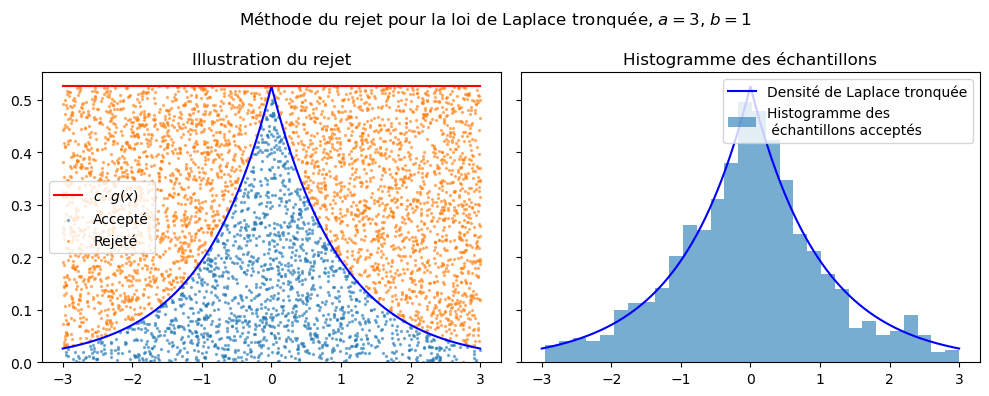

In [4]:
xx = np.linspace(-a, a, 1000)
true_pdf = distrib.pdf(xx) / (distrib.cdf(a) - distrib.cdf(-a))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True, layout='tight')

ax1.plot(xx, true_pdf, color='blue')
ax1.plot(xx, c*g * np.ones_like(xx), color='red', linestyle='-', label=r"$c \cdot g(x)$",)
ax1.scatter(sample[accepted], c*g * unif_test[accepted], s=2, alpha=0.5, label='Accepté')
ax1.scatter(sample[rejected], c*g * unif_test[rejected], s=2, alpha=0.5, label='Rejeté')
ax1.set_title("Illustration du rejet")
ax1.legend()


ax2.plot(xx, true_pdf, color='blue', label='Densité de Laplace tronquée')
ax2.hist(sample[accepted], bins=30, density=True, alpha=0.6, color='C0', label='Histogramme des\n échantillons acceptés')
ax2.legend(loc='upper right')
ax2.set_title("Histogramme des échantillons")

fig.suptitle(r'Méthode du rejet pour la loi de Laplace tronquée, $a=$' + f'{a}, $b={b}$')
plt.show()

La ligne rouge représente $c g(x)$ avec une constante $c$ telle que $f_{\text{trunc}}(x) \leq c g(x)$ pour tout $x \in [-a,a]$, où $f_{\text{trunc}}$ est la densité **normalisée** de la loi de Laplace tronquée. 

##### On peut également comparer le taux d'acceptation de la méthode en fonction de la taille de l'intervalle de troncature choisi.

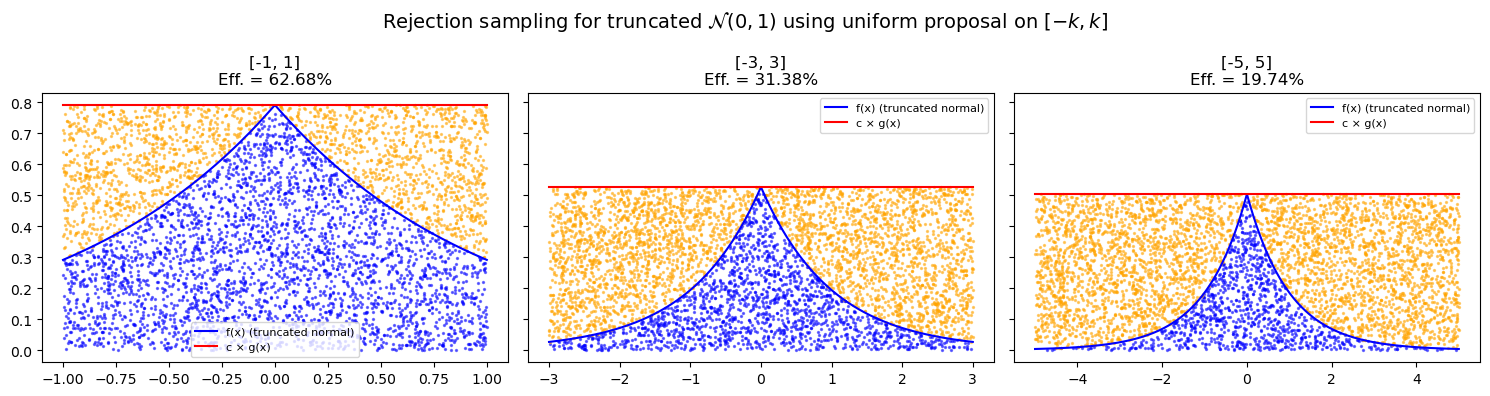

In [5]:
b = 1
size = 5000
rng = np.random.default_rng()
distrib = stats.laplace(scale=b)

intervals = [(-1, 1), (-3, 3), (-5, 5)]
efficiencies = {}
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharey=True, layout='tight')

for ax, (a0, a) in zip(axes, intervals):
    k = a     # 区间是 [-k, k]
    
    Z = distrib.cdf(k) - distrib.cdf(-k)    # 定义 f(x) 的归一化常数
    
    c = a / (b * Z)    # 根据定义计算 c

    sample = rng.uniform(a0, a, size)
    unif_test = rng.random(size)

    g_pdf = 1 / (2 * k)    # g(x) 是均匀密度
    f_vals = distrib.pdf(sample) / Z     # f(x) 是截断正态密度

    accepted = unif_test < f_vals / (c * g_pdf)
    rejected = ~accepted
    efficiency = np.mean(accepted)
    efficiencies[(a0, a)] = efficiency

    xx = np.linspace(a0, a, 1000)
    fx = distrib.pdf(xx) / Z
    gx = np.ones_like(xx) / (a - a0)

    ax.plot(xx, fx, color='blue', label='f(x) (truncated normal)')
    ax.plot(xx, c * gx, color='red', label='c × g(x)')
    ax.scatter(sample[accepted], unif_test[accepted] * c * g_pdf, s=2, alpha=0.5, color='blue')
    ax.scatter(sample[rejected], unif_test[rejected] * c * g_pdf, s=2, alpha=0.5, color='orange')
    ax.set_title(f"[{a0}, {a}]\nEff. = {efficiency:.2%}")
    ax.legend(fontsize=8)

fig.suptitle(r"Rejection sampling for truncated $\mathcal{N}(0, 1)$ using uniform proposal on $[-k, k]$", fontsize=14)
plt.show()

Ce phénomène est cohérent avec la relation entre le taux d'acceptation et la constante $c$ : en élargissant l'intervalle de troncature, la densité auxiliaire $g$ devient de moins en moins adaptée à la densité cible $f$, ce qui entraîne une augmentation de $c$ et donc une diminution du taux d'acceptation.

##### ***- Intervalle asymétrique***
Grâce à la symétrie de la densité, il suffit d'étudier les deux cas suivants :

- Cas 1 : tronquée sur un intervalle $[s,t]$ tel que $s < 0 < t$ (intervalle asymétrique contenant zéro).

- Cas 2 : tronquée sur un intervalle $[s,t]$ tel que $0 < s < t$ (intervalle asymétrique strictement positif).

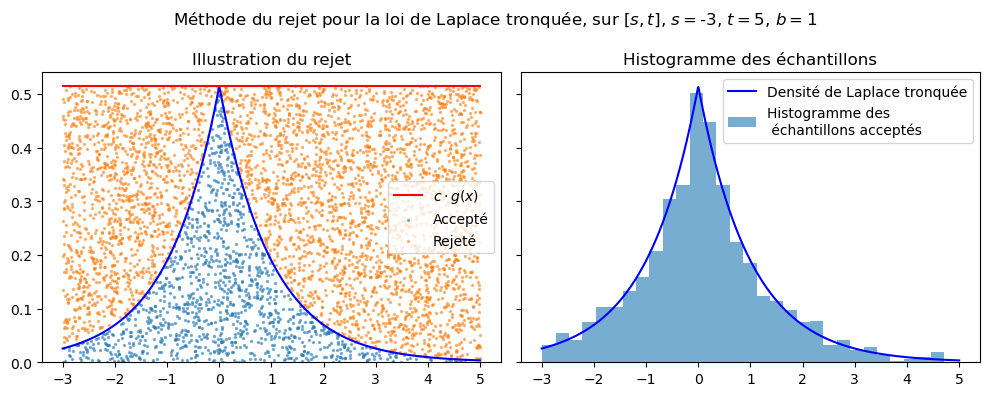

In [19]:
s,t,b = -3,5,1
distrib = stats.laplace(scale=b)
Z = distrib.cdf(t) - distrib.cdf(s)
g = 1/(t-s)

res = optimize.minimize_scalar(lambda x: -distrib.pdf(x) / (g*Z), bounds=(s, t), method="bounded")

c = -res.fun

rng = np.random.default_rng()
size = 5000

sample = rng.uniform(low=s, high=t, size=size)
pdf_truncated = distrib.pdf(sample) / Z            #la densité normalisée
unif_test = rng.random(size=size)

accepted = unif_test * c/(t-s) < pdf_truncated
rejected = np.logical_not(accepted)

xx = np.linspace(s, t, 1000)
true_pdf = distrib.pdf(xx) / (distrib.cdf(t) - distrib.cdf(s))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True, layout='tight')

ax1.plot(xx, true_pdf, color='blue')
ax1.plot(xx, c*g * np.ones_like(xx), color='red', linestyle='-', label=r"$c \cdot g(x)$",)
ax1.scatter(sample[accepted], c*g * unif_test[accepted], s=2, alpha=0.5, label='Accepté')
ax1.scatter(sample[rejected], c*g * unif_test[rejected], s=2, alpha=0.5, label='Rejeté')
ax1.set_title("Illustration du rejet")
ax1.legend()


ax2.plot(xx, true_pdf, color='blue', label='Densité de Laplace tronquée')
ax2.hist(sample[accepted], bins=30, density=True, alpha=0.6, color='C0', label='Histogramme des\n échantillons acceptés')
ax2.legend(loc='upper right')
ax2.set_title("Histogramme des échantillons")

fig.suptitle(r'Méthode du rejet pour la loi de Laplace tronquée, sur $[s, t]$, $s=$' + f'{s}, $t={t}$, $b={b}$')
plt.show()

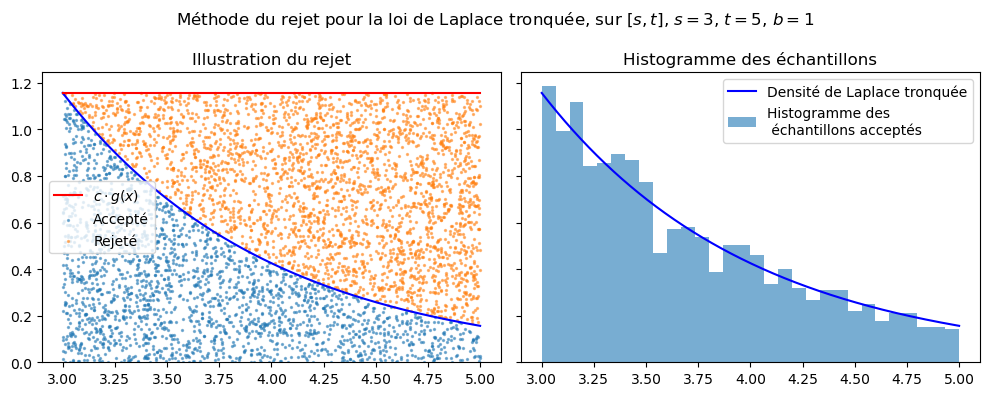

In [20]:
s,t,b = 3,5,1
distrib = stats.laplace(scale=b)
Z = distrib.cdf(t) - distrib.cdf(s)
g = 1/(t-s)

res = optimize.minimize_scalar(lambda x: -distrib.pdf(x) / (g*Z), bounds=(s, t), method="bounded")

c = -res.fun

rng = np.random.default_rng()
size = 5000

sample = rng.uniform(low=s, high=t, size=size)
pdf_truncated = distrib.pdf(sample) / Z            #la densité normalisée
unif_test = rng.random(size=size)

accepted = unif_test * c/(t-s) < pdf_truncated
rejected = np.logical_not(accepted)

xx = np.linspace(s, t, 1000)
true_pdf = distrib.pdf(xx) / (distrib.cdf(t) - distrib.cdf(s))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True, layout='tight')

ax1.plot(xx, true_pdf, color='blue')
ax1.plot(xx, c*g * np.ones_like(xx), color='red', linestyle='-', label=r"$c \cdot g(x)$",)
ax1.scatter(sample[accepted], c*g * unif_test[accepted], s=2, alpha=0.5, label='Accepté')
ax1.scatter(sample[rejected], c*g * unif_test[rejected], s=2, alpha=0.5, label='Rejeté')
ax1.set_title("Illustration du rejet")
ax1.legend()


ax2.plot(xx, true_pdf, color='blue', label='Densité de Laplace tronquée')
ax2.hist(sample[accepted], bins=30, density=True, alpha=0.6, color='C0', label='Histogramme des\n échantillons acceptés')
ax2.legend(loc='upper right')
ax2.set_title("Histogramme des échantillons")

fig.suptitle(r'Méthode du rejet pour la loi de Laplace tronquée, sur $[s, t]$, $s=$' + f'{s}, $t={t}$, $b={b}$')
plt.show()

#### 2.2.2 Simulation en bidimension $d = 2$

Après avoir étudié le cas unidimensionnel, nous passons maintenant à l'analyse en **dimension deux** en utilisant également des visualisations graphiques.

In [48]:
# Paramètres
a, b = 3, 1
distrib = stats.laplace(scale=b)

# Constante de normalisation Z = P([-a, a])^2 car densité bidimensionnelle indépendante
Z1d = distrib.cdf(a) - distrib.cdf(-a)
Z2d = Z1d ** 2

# Densité uniforme sur le carré [-a, a] x [-a, a]
g = 1 / (4 * a**2)

# Maximisation de f(x,y)/g(x,y), ici f(x,y) = f(x)*f(y) et g(x,y) = constante
res = optimize.minimize_scalar(
    lambda x: -distrib.pdf(x)**2 / (g * Z2d), bounds=(-a, a), method="bounded"
)
c = -res.fun
print("Valeur optimale c* :", c)
print("Valeur théorique :", a**2 / (b**2 * Z2d))

# Génération d'échantillons
rng = np.random.default_rng()
size = 10000

x = rng.uniform(low=-a, high=a, size=size)
y = rng.uniform(low=-a, high=a, size=size)
samples = np.column_stack((x, y))

# Densité cible normalisée f(x,y)/Z2d
pdf_vals = distrib.pdf(x) * distrib.pdf(y) / Z2d

# Test d'acceptation
unif_test = rng.random(size=size)
accepted = unif_test * c * g < pdf_vals
rejected = ~accepted

accepted_samples = samples[accepted]

Valeur optimale c* : 9.967830317939825
Valeur théorique : 9.967830317939839


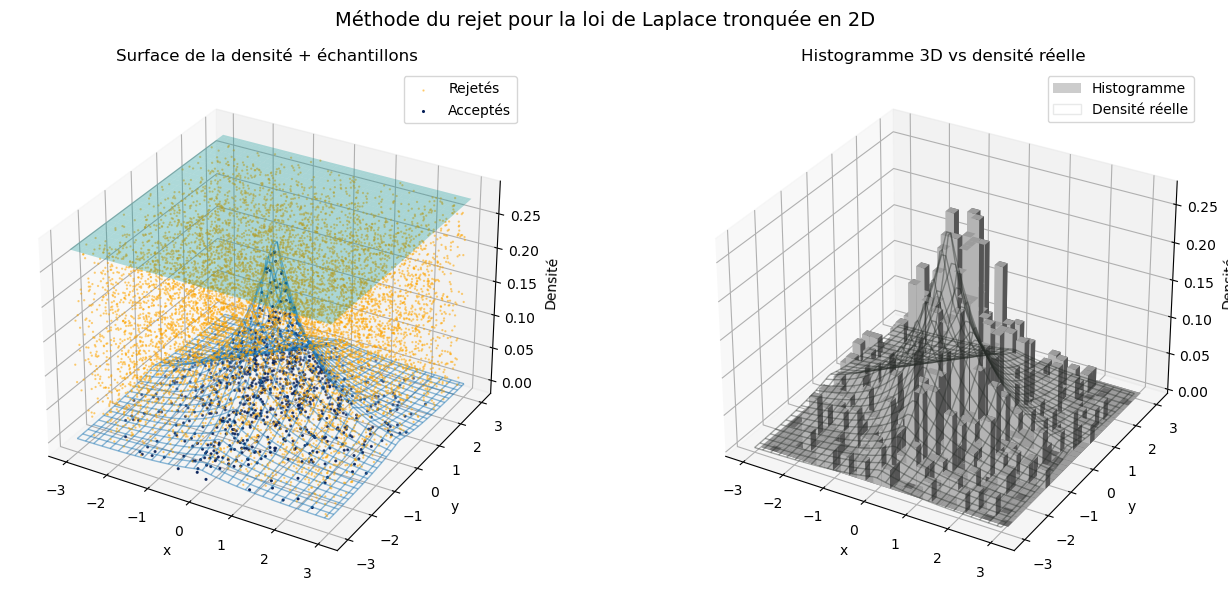

In [51]:
# ----------------------
# PARAMÈTRES
# ----------------------
a, b = 3, 1
distrib = stats.laplace(scale=b)

Z1d = distrib.cdf(a) - distrib.cdf(-a)
Z2d = Z1d ** 2
g = 1 / (4 * a**2)
c = a**2 / (b**2 * Z2d)  # Théorique

# ----------------------
# ÉCHANTILLONNAGE
# ----------------------
rng = np.random.default_rng()
size = 10000

x = rng.uniform(-a, a, size)
y = rng.uniform(-a, a, size)
samples = np.column_stack((x, y))

pdf_vals = distrib.pdf(x) * distrib.pdf(y) / Z2d
unif_test = rng.random(size)
accepted = unif_test * c * g < pdf_vals
rejected = ~accepted

accepted_samples = samples[accepted]
rejected_samples = samples[rejected]

z_all = unif_test * c * g
z_accept = z_all[accepted]
z_reject = z_all[rejected]

# ----------------------
# GRILLE POUR DENSITÉS
# ----------------------
grid_size = 60
X, Y = np.meshgrid(np.linspace(-a, a, grid_size), np.linspace(-a, a, grid_size))
Z_target = distrib.pdf(X) * distrib.pdf(Y) / Z2d
Z_proposal = c * g * np.ones_like(X)

# ----------------------
# FIGURE
# ----------------------
fig = plt.figure(figsize=(14, 6))

# --- GAUCHE : DENSITÉS + POINTS ---
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_wireframe(X, Y, Z_target, cmap='YlGnBu', alpha=0.5, linewidth=1)
ax1.plot_surface(X, Y, Z_proposal, color='c', alpha=0.3)

ax1.scatter(rejected_samples[:, 0], rejected_samples[:, 1],
            z_reject,
            color='orange', s=0.4, alpha=0.5, label='Rejetés')
ax1.scatter(accepted_samples[:, 0], accepted_samples[:, 1],
            z_accept,
            color='#041e57', s=1.5, label='Acceptés')



ax1.set_title("Surface de la densité + échantillons")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("Densité")
ax1.legend()

# --- DROITE : HISTOGRAMME + DENSITÉ RÉELLE ---
ax2 = fig.add_subplot(122, projection='3d')

# Histogramme 2D
hist, xedges, yedges = np.histogram2d(
    accepted_samples[:, 0], accepted_samples[:, 1],
    bins=30, range=[[-a, a], [-a, a]], density=True)

xpos, ypos = np.meshgrid((xedges[:-1] + xedges[1:]) / 2,
                         (yedges[:-1] + yedges[1:]) / 2, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)
dz = hist.ravel()
dx = dy = (2 * a) / 30

# Barres 3D
ax2.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', alpha=1, color='#cccccc')

# Surface réelle（更透明）
ax2.plot_wireframe(X, Y, Z_target, color='#272c28', alpha=0.4, linewidth=1)

# Légende manuelle
legend_elements = [
    Patch(facecolor='#cccccc', label='Histogramme'),
    Patch(facecolor='white', edgecolor='#272c28', alpha=0.1, label='Densité réelle')
]

ax2.legend(handles=legend_elements)
ax2.set_title("Histogramme 3D vs densité réelle")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("Densité")

# Titre global
fig.suptitle(r"Méthode du rejet pour la loi de Laplace tronquée en 2D", fontsize=14)
plt.tight_layout()
plt.show()

Les visualisations montrent que :

- Les échantillons acceptés sont majoritairement concentrés autour de l'origine, où la densité cible atteint son maximum.  
  En s'éloignant du centre, la densité décroît rapidement, rendant les acceptations beaucoup plus rares.

- Le passage en dimension 2 entraîne une forte diminution du taux d'acceptation global.  

Cela s'explique par le fait que la densité de la loi de Laplace bidimensionnelle est très concentrée, alors que la densité auxiliaire uniforme est répartie sur un large domaine, augmentant ainsi la probabilité de rejet.

#### 2.2.3 Cas de dimension plus élevée :
Lorsque l'on étend le modèle de la dimension unidimensionnelle aux espaces de plus grande dimension, les performances de la méthode du rejet diminuent généralement de manière drastique. Plus précisément, le taux d'acceptation chute rapidement avec l'augmentation de la dimension. 

Ce phénomène sera démontré rigoureusement d'un point de vue mathématique, puis confirmé par des simulations numériques.

##### ***- Analyse théorique***

Considérons la loi de Laplace tronquée définie sur l'hypercube de troncature $[-a, a]^d$, dont la densité est donnée par :

$$
f(x) = \frac{e^{-\|x\|_1}}{\int_{[-a,a]^d} e^{-\|x\|_1} \, dx}, \quad x \in [-a,a]^d.
$$

Nous choisissons comme loi auxiliaire la loi uniforme sur le même domaine, dont la densité est :

$$
g(x) = \frac{1}{(2a)^d}, \quad x \in [-a,a]^d.
$$

La probabilité d'acceptation de la méthode du rejet est alors :

$$
P_{\text{accept}} = \frac{1}{M}, \quad M = \max_{x \in [-a,a]^d} \frac{f(x)}{g(x)}.
$$

En utilisant l'expression de $g(x)$, on a :

$$
\frac{f(x)}{g(x)} = (2a)^d \cdot \frac{e^{-\|x\|_1}}{\int_{[-a,a]^d} e^{-\|x\|_1} \, dx}.
$$

On observe que la fonction $\|x\|_1$ est minimale en $x=0$, d'où :

$$
M = \frac{f(0)}{g(0)} = (2a)^d \cdot \frac{1}{\int_{[-a,a]^d} e^{-\|x\|_1} \, dx}.
$$

Calculons maintenant l'intégrale au dénominateur :

$$
\int_{[-a,a]^d} e^{-\|x\|_1} \, dx = \left( \int_{-a}^{a} e^{-|x|} \, dx \right)^d = \left( 2 \int_{0}^{a} e^{-x} \, dx \right)^d = \left( 2(1 - e^{-a}) \right)^d.
$$

Ainsi, la constante $M$ devient :

$$
M = \frac{(2a)^d}{[2(1 - e^{-a})]^d} = \left( \frac{a}{1 - e^{-a}} \right)^d. \tag{2}
$$

La probabilité d'acceptation est donc :

$$
P_{\text{accept}} = \frac{1}{M} = \left( \frac{1 - e^{-a}}{a} \right)^d.
$$

Comme pour tout $a > 0$ on a $1 - e^{-a} < a$, il en découle que :

$$
0 < \frac{1 - e^{-a}}{a} < 1.
$$

Par conséquent, lorsque $d \to \infty$, on obtient :

$$
\lim_{d \to \infty} P_{\text{accept}} = \left( \frac{1 - e^{-a}}{a} \right)^d = 0.
$$

Ce résultat montre que la probabilité d'acceptation décroît **de manière exponentielle** avec la dimension, rendant la méthode du rejet inefficace en grande dimension.

$\blacksquare$

##### ***- Simulation numérique***
Afin d'illustrer l'évolution du taux d'acceptation en fonction de la dimension, nous avons tracé le taux d'acceptation corrigé en fonction de la dimension $d$. L'axe des ordonnées est représenté en échelle logarithmique, qui permet de transformer une décroissance exponentielle en une décroissance linéaire, afin de mieux visualiser la décroissance exponentielle attendue.

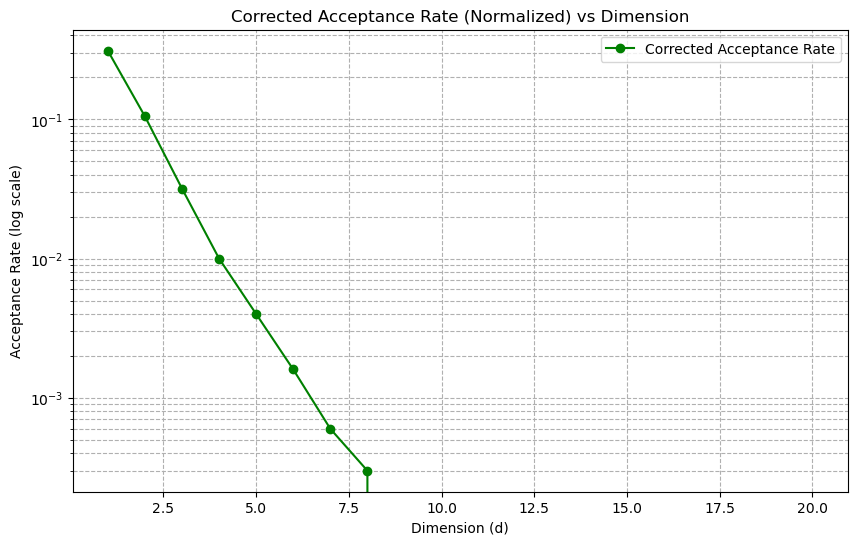

In [7]:
def truncated_laplace_density_normalized(x, a, d):
    normalization_const = (2 * (1 - np.exp(-a)))**d
    return np.exp(-np.sum(np.abs(x), axis=1)) / normalization_const

def simulate_acceptance_rate_corrected(a, d, num_samples=10000):
    samples = np.random.uniform(-a, a, size=(num_samples, d))
    densities = truncated_laplace_density_normalized(samples, a, d)    # 归一化后的目标密度
    auxiliary_density = 1 / (2 * a)**d
    
    f0 = truncated_laplace_density_normalized(np.zeros((1, d)), a, d)[0]
    g0 = auxiliary_density
    M = f0 / g0
    
    acceptance_probs = densities / (M * auxiliary_density)    # 接受概率
    
    u = np.random.uniform(0, 1, num_samples)
    accepted = np.sum(u < acceptance_probs)
    
    acceptance_rate = accepted / num_samples
    return acceptance_rate

# 参数设置
a = 3
dims = range(1, 21)
acceptance_rates_corrected = [simulate_acceptance_rate_corrected(a, d) for d in dims]

# 绘图展示
plt.figure(figsize=(10, 6))
plt.plot(dims, acceptance_rates_corrected, marker='o', color='green', label='Corrected Acceptance Rate')
plt.yscale('log')
plt.xlabel('Dimension (d)')
plt.ylabel('Acceptance Rate (log scale)')
plt.title('Corrected Acceptance Rate (Normalized) vs Dimension')
plt.grid(True, linestyle='--', which='both')
plt.legend()
plt.show()

La courbe obtenue est quasi linéaire en échelle logarithmique décroissante, ce qui confirme rigoureusement notre analyse théorique.

### 2.3 Peut-on utiliser la loi de Laplace pour simuler la loi normale ?
Dans les cas de grande dimension, une question naturelle se pose :  peut-on améliorer le taux d’acceptation en choisissant une loi auxiliaire plus proche de la loi cible, telle que le Laplace ?

En effet, la faible efficacité observée en haute dimension résulte en partie d’un mauvais ajustement entre les densités $f$ (cible) et $g$ (auxiliaire). Il est donc légitime d’envisager l’usage d’une densité auxiliaire *plus adaptée à la forme de $f$*, dans l’objectif de réduire la constante de majoration $c$ et ainsi augmenter le taux d’acceptation.

Nous commençons par tester cette idée en utilisant une **densité gaussienne** comme loi auxiliaire pour approximer le Laplace tronqué en dimension 1.

Constante optimale c = 5.8004
Taux d'acceptation ≈ 17.27%
Nombre d'échantillons acceptés : 1727


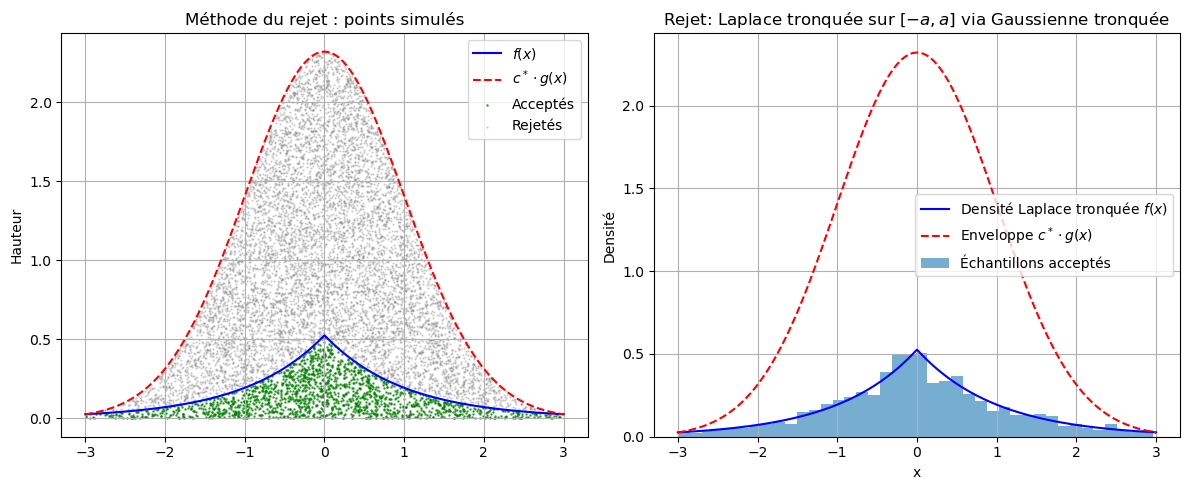

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, laplace

# -----------------------
# Paramètres
# -----------------------
sample_size = 10000
a = 3
rng = np.random.default_rng()

# -----------------------
# Densité cible : Laplace tronquée
# -----------------------
def laplace_pdf_truncated(x, a):
    Z = laplace.cdf(a) - laplace.cdf(-a)
    return 0.5 * np.exp(-np.abs(x)) / Z * (np.abs(x) <= a)

# -----------------------
# Densité de proposition : Gaussienne tronquée N(0,1) sur [-a, a]
# -----------------------
trunc_gauss = truncnorm(a=-a, b=a, loc=0, scale=1)
x = trunc_gauss.rvs(size=sample_size, random_state=rng)
u = rng.random(size=sample_size)

f_x = laplace_pdf_truncated(x, a)
g_x = trunc_gauss.pdf(x)

# -----------------------
# Constante d’enveloppe optimale c*
# -----------------------
M = np.max(f_x / g_x)
print(f"Constante optimale c = {M:.4f}")

# -----------------------
# Rejection sampling
# -----------------------
accepted = u < f_x / (M * g_x)
x_accepted = x[accepted]
x_rejected = x[~accepted]
u_accepted = u[accepted]
u_rejected = u[~accepted]
acceptance_rate = np.mean(accepted)

# -----------------------
# Affichage
# -----------------------
xx = np.linspace(-a, a, 1000)
f_xx = laplace_pdf_truncated(xx, a)
g_xx = trunc_gauss.pdf(xx)
c_g_xx = M * g_xx

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), layout='tight', sharex=True)

# --- Gauche : points simulés
ax1.plot(xx, f_xx, label=r"$f(x)$", color='blue')
ax1.plot(xx, c_g_xx, '--', label=r"$c^* \cdot g(x)$", color='red')
ax1.scatter(x_accepted, u_accepted * M * g_x[accepted], s=0.8, alpha=0.6, label='Acceptés', color='green')
ax1.scatter(x_rejected, u_rejected * M * g_x[~accepted], s=0.5, alpha=0.3, label='Rejetés', color='gray')
ax1.set_title("Méthode du rejet : points simulés")
ax1.set_ylabel("Hauteur")
ax1.legend()
ax1.grid(True)

# --- Droite : histogramme + densité
ax2.plot(xx, f_xx, label=r"Densité Laplace tronquée $f(x)$", color='blue')
ax2.plot(xx, c_g_xx, '--', label=r"Enveloppe $c^* \cdot g(x)$", color='red')
ax2.hist(x_accepted, bins=40, density=True, alpha=0.6, label='Échantillons acceptés')
ax2.set_title(r"Rejet: Laplace tronquée sur $[-a,a]$ via Gaussienne tronquée")
ax2.set_xlabel("x")
ax2.set_ylabel("Densité")
ax2.legend()
ax2.grid(True)

# --- Affichage taux d'acceptation
print(f"Taux d'acceptation ≈ {acceptance_rate:.2%}")
print(f"Nombre d'échantillons acceptés : {len(x_accepted)}")

plt.show()

Nous constatons que, lorsque l’on utilise une densité gaussienne comme loi auxiliaire pour simuler une loi de Laplace tronquée, le taux d’acceptation est déjà relativement faible en dimension 1. Cela suggère que cette approche est peu adaptée aux cas de grande dimension.

En effet, pour respecter l’inégalité de domination $f(x) \leq c \cdot g(x)$ sur l’intervalle de troncature tout en assurant la normalisation de $g$, il est souvent nécessaire de choisir une densité auxiliaire qui s’écarte significativement de $f$ au voisinage de $x = 0$, ce qui pénalise fortement l’acceptation.

Cela soulève naturellement une question inverse : **peut-on utiliser une loi de Laplace comme densité auxiliaire pour simuler une loi gaussienne tronquée ?**  
Pour examiner cette possibilité, nous formulons la proposition suivante.

### 2.4 Proposition

**Proposition.**  
Soient $f : x \mapsto \dfrac{1}{\sqrt{2\pi}} e^{-x^2/2}$ la densité de la loi $\mathcal{N}(0,1)$, et $g : x \mapsto \dfrac{1}{2} e^{-|x|}$ la densité de la loi de Laplace.  
Alors, il existe une constante $c = \sqrt{\dfrac{2e}{\pi}}$ telle que :

$$
f(x) \leq c \cdot g(x), \quad \forall x \in \mathbb{R}.
$$

---

*Démonstration.*  
On considère le rapport des densités :

$$
\frac{f(x)}{g(x)} = \frac{1}{\sqrt{2\pi}} e^{-x^2/2} \cdot \frac{2}{e^{-|x|}} = \frac{2}{\sqrt{2\pi}} e^{-x^2/2 + |x|}.
$$

La fonction est paire, il suffit donc d'étudier le cas $x \geq 0$. Ainsi :

$$
\frac{f(x)}{g(x)} = \frac{2}{\sqrt{2\pi}} e^{-x^2/2 + x}.
$$

On maximise cette expression en résolvant :

$$
\phi(x) = -\frac{x^2}{2} + x \Rightarrow \phi'(x) = -x + 1 = 0 \Rightarrow x = 1.
$$

Donc le maximum est atteint en $x = 1$ et vaut :

$$
\frac{f(1)}{g(1)} = \frac{2}{\sqrt{2\pi}} e^{1/2} = \frac{2e^{1/2}}{\sqrt{2\pi}}
$$

Par conséquent :

$$
f(x) \leq \sqrt{\dfrac{2e}{\pi}} \cdot g(x), \quad \forall x \in \mathbb{R}.
$$

$\blacksquare$

---
On en déduire une fonction simulant un échantillon de loi normale N(0, 1).

## 3. Gaussienne

## 4. Comparaision

### Peut-on utiliser la loi de Laplace pour simuler la loi normale, ou l’inverse ?

### 1. En théorie, les deux sont possibles...

Dans le cadre de la méthode du rejet, on peut utiliser **n'importe quelle densité auxiliaire $g$** pour simuler une loi cible $f$, à condition qu’il existe une constante $c > 0$ telle que :

$$
f(x) \leq c \cdot g(x), \quad \forall x.
$$

Donc **on peut théoriquement simuler la loi normale à l'aide de la loi de Laplace**, ou l’inverse — selon les besoins.

---

### 2. Mais en pratique : il vaut mieux utiliser Laplace pour simuler la loi normale

#### Exemple : 

- Loi cible $f(x) = \dfrac{1}{\sqrt{2\pi}} e^{-x^2/2}$ (normale standard)  
- Loi auxiliaire $g(x) = \dfrac{1}{2} e^{-|x|}$ (Laplace)  
- On a démontré que :

$$
f(x) \leq \dfrac{2e}{\pi} \cdot g(x)
$$

Cela donne un **taux d’acceptation** raisonnable :

$$
\text{acceptance rate} = \frac{1}{c} = \frac{\pi}{2e} \approx 0{,}58
$$

#### Inversement :

- Si on veut utiliser la loi normale comme loi auxiliaire pour simuler la loi de Laplace :

$$
\dfrac{1}{2} e^{-|x|} \leq c \cdot \dfrac{1}{\sqrt{2\pi}} e^{-x^2/2}
$$

Cette inégalité **n’est pas vraie** quand $x \to \infty$, car $e^{-|x|}$ décroît **moins vite** que $e^{-x^2/2}$.

Donc **aucune constante $c$ finie ne permet cette majoration** sur tout $\mathbb{R}$.

---

### 3. Conclusion

| Loi cible        | Loi auxiliaire | Faisable ? | Taux d’acceptation |
|------------------|----------------|------------|---------------------|
| **Normale**      | Laplace        | Oui        | Environ 58 %        |
| Laplace          | Normale        | **Non**    | Impossible          |

**Il est donc préférable d’utiliser la loi de Laplace pour simuler la loi normale** avec la méthode du rejet. L’inverse n’est pas faisable car la loi normale ne majore pas la loi de Laplace sur tout $\mathbb{R}$.